# Evalution and Analysis

## Imports:

In [1]:
from pathlib import Path
from Helper.evaluation_helpers import get_predictions, calc_metrics, error_plot,plot_metric
from Training.Helper.PyTorchModular import HORIZONS
import warnings
from matplotlib import pyplot as plt

### Supress warnings

In [2]:
warnings.filterwarnings("ignore") 

In [3]:
import numpy as np
import os
from pathlib import Path

predsPath = os.path.join('..', 'Predictions')
horizonPaths = [f'Horizon{horizon}' for horizon in HORIZONS]
for horizonPath in horizonPaths:
    print(f'{horizonPath}:')
    for i in list(Path(os.path.join(predsPath, horizonPath)).glob('*.npy')):
        data = np.load(i)
        print(f" {i.name} has {len(data)} values")  # Show length of each prediction file


Horizon1:
 ARDL_horizon_1.npy has 12 values
 ARIMA1990_horizon_1.npy has 12 values
 ARIMAX1990_horizon_1.npy has 12 values
 GRU1990_horizon_1.npy has 77 values
 LSTM_horizon_1.npy has 12 values
 Naive_horizon_1.npy has 12 values
 NBEATSx1990_horizon_1.npy has 12 values
 NHITS1990_horizon_1.npy has 12 values
 RNN1990_horizon_1.npy has 77 values
 SARIMA1990_horizon_1.npy has 12 values
 SARIMAX1990_horizon_1.npy has 12 values
 TCN_horizon_1.npy has 12 values
 TFT_horizon_1.npy has 12 values
 VARccf_horizon_1.npy has 12 values
 VARcointegration_horizon_1.npy has 12 values
 XGB1990_horizon_1.npy has 80 values
Horizon3:
 ARDL_horizon_3.npy has 12 values
 GRU1990_horizon_3.npy has 77 values
 LSTM_horizon_3.npy has 12 values
 Naive_horizon_3.npy has 12 values
 NBEATSx1990_horizon_3.npy has 12 values
 NHITS1990_horizon_3.npy has 12 values
 RNN1990_horizon_3.npy has 77 values
 TCN_horizon_3.npy has 12 values
 TFT_horizon_3.npy has 12 values
 VARccf_horizon_3.npy has 12 values
 VARcointegration_h

In [4]:
# metric DataFrames are sorted by the main metric before being displayed
main_metric = 'RMSE'

# Horizon = 1:

,RMSE,MAE,r2
ARIMAX1990,0.261509,0.215859,0.873131
SARIMAX1990,0.269689,0.25457,0.865069
ARIMA1990,0.278222,0.22374,0.856396
Naive,0.292784,0.26025,0.84097
SARIMA1990,0.33694,0.285122,0.789385
TCN,0.471641,0.399372,0.587325
VARcointegration,0.558785,0.505504,0.420741
VARccf,0.626305,0.611547,0.272295
LSTM,1.602009,1.278878,-3.761173
ARDL,2.640828,2.610789,-11.937913


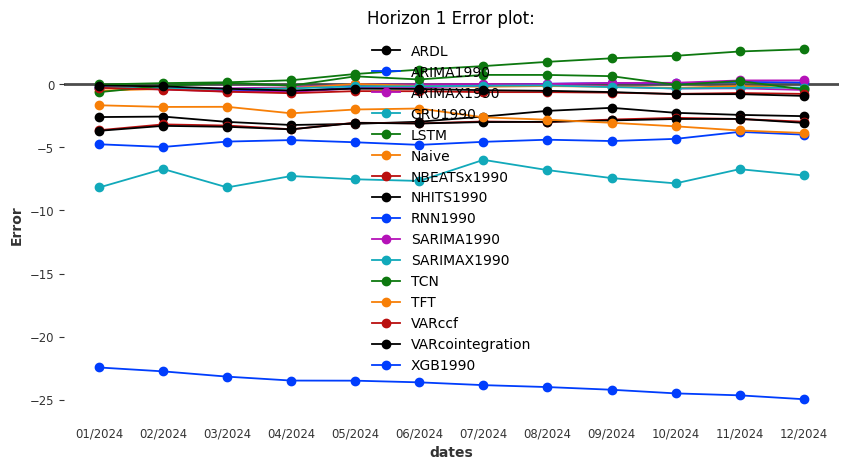

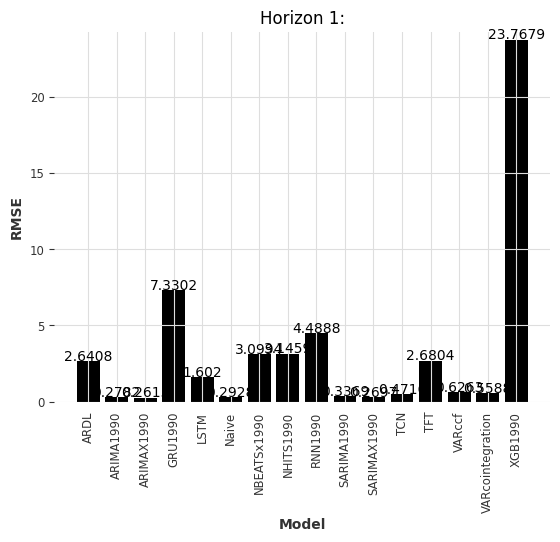

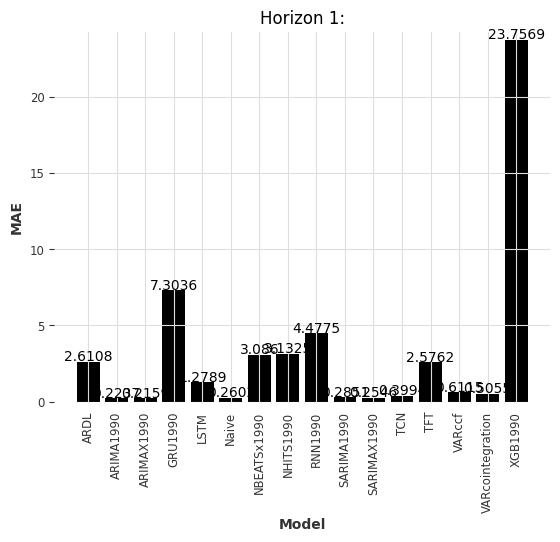

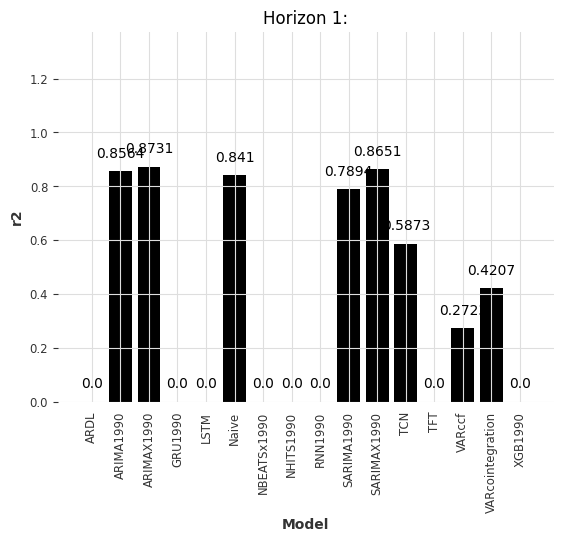

In [5]:
predsPath_1= Path('../Predictions/Horizon1')
predsDf_1=get_predictions(predsPath_1)

metrics_1= calc_metrics(predsDf_1)
display(metrics_1.sort_values(main_metric, axis=0))

error_plot(predsDf_1,model='all',absolute=False, title= 'Horizon 1 Error plot:')

for i in metrics_1.columns:
    plot_metric(metrics_1,i,model='all', title='Horizon 1:')

# Horizon = 3:

,RMSE,MAE,r2
Naive,0.616129,0.5375,0.295748
TCN,0.803654,0.692917,-0.198181
VARccf,0.835942,0.798191,-0.296393
VARcointegration,0.939982,0.879776,-0.639167
LSTM,0.960128,0.758273,-0.710182
TFT,2.067248,1.758727,-6.928104
ARDL,2.537766,2.492736,-10.947779
NBEATSx1990,3.24316,3.212337,-18.512858
NHITS1990,3.245888,3.214122,-18.545702
GRU1990,7.344475,7.324929,-99.070388


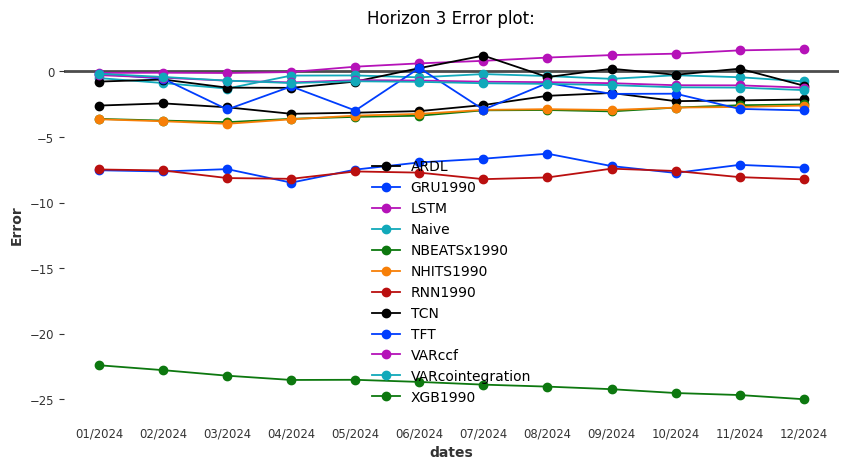

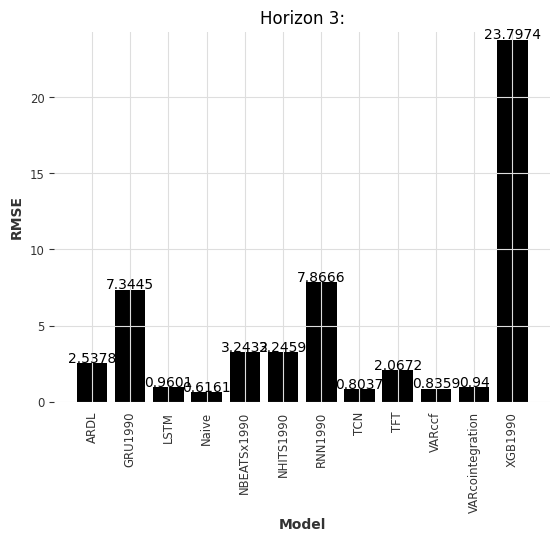

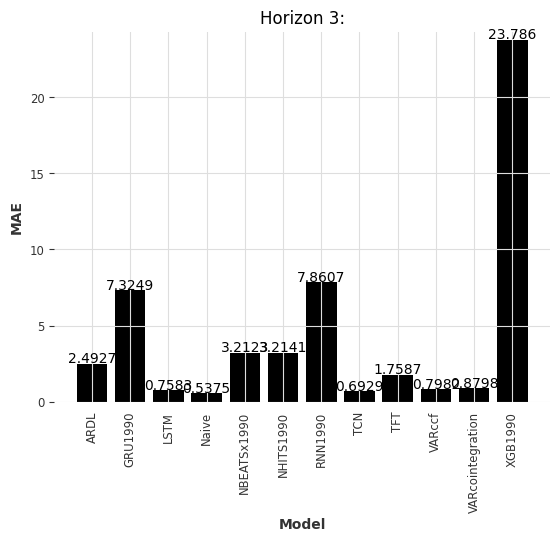

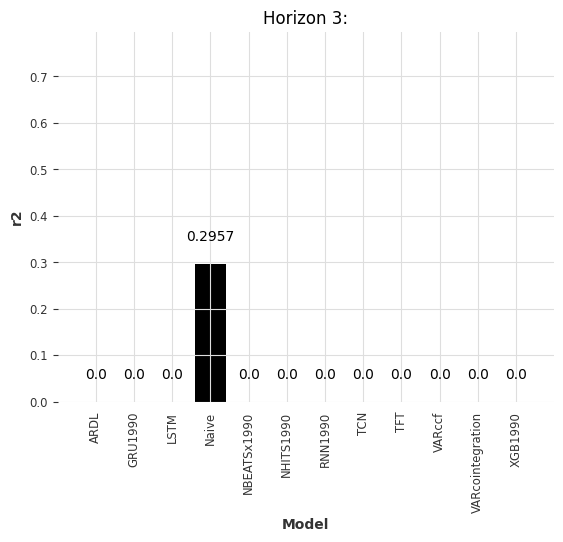

In [6]:
predsPath_3= Path('../Predictions/Horizon3')
predsDf_3=get_predictions(predsPath_3)

metrics_3= calc_metrics(predsDf_3)
display(metrics_3.sort_values(main_metric, axis=0))

error_plot(predsDf_3,model='all',absolute=False, title= 'Horizon 3 Error plot:')
for i in metrics_3.columns:
    plot_metric(metrics_3,i, title='Horizon 3:')

# Horizon = 6:

,RMSE,MAE,r2
TCN,0.894473,0.798288,-0.484291
Naive,1.127616,1.0075,-1.358883
VARccf,1.17718,1.109972,-1.570811
VARcointegration,1.21846,1.12629,-1.754269
ARDL,2.271809,2.233214,-8.574754
NHITS1990,3.326016,3.300174,-19.522616
NBEATSx1990,3.476542,3.450648,-21.422246
TFT,4.017051,3.970676,-28.93634
GRU1990,4.272294,3.82898,-32.861521
LSTM,5.346032,4.639163,-52.02092


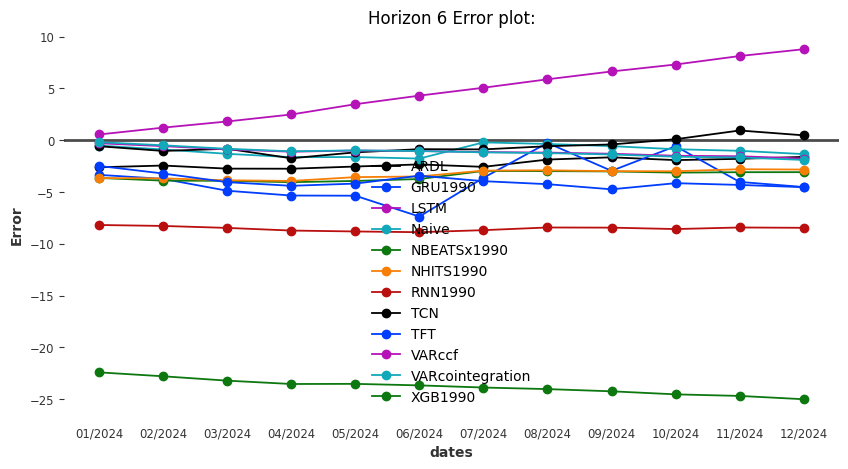

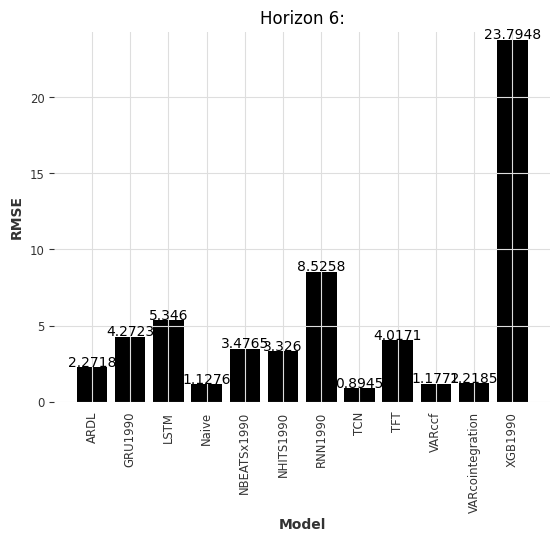

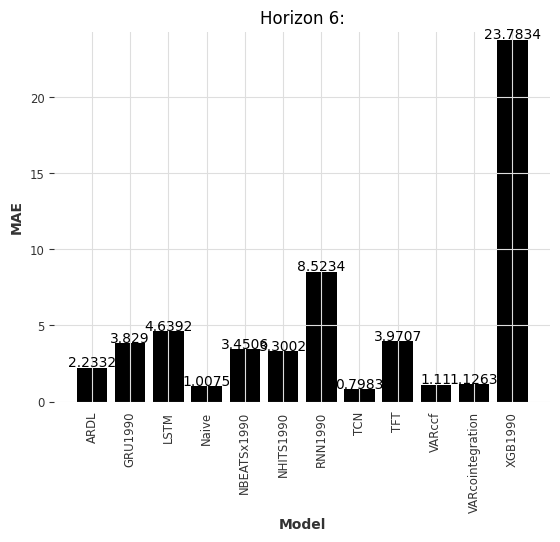

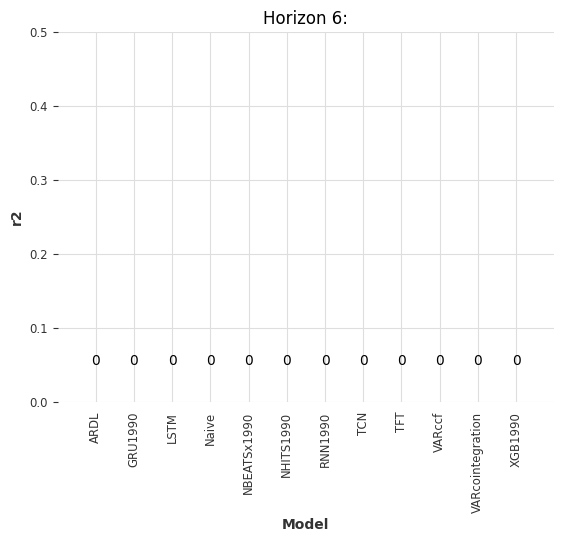

In [7]:
predsPath_6= Path('../Predictions/Horizon6')
predsDf_6=get_predictions(predsPath_6)

metrics_6= calc_metrics(predsDf_6)
display(metrics_6.sort_values(main_metric, axis=0))

error_plot(predsDf_6,model='all',absolute=False, title= 'Horizon 6 Error plot:')
for i in metrics_6.columns:
    plot_metric(metrics_6,i, title='Horizon 6:')

# Horizon = 12:

,RMSE,MAE,r2
VARcointegration,1.780569,1.622156,-4.881682
VARccf,1.785207,1.627247,-4.912367
Naive,2.028525,1.891,-6.633873
ARDL,2.108911,2.017296,-7.250887
TCN,2.978409,2.617966,-15.457082
NHITS1990,3.817656,3.814612,-26.038188
NBEATSx1990,4.143827,4.138137,-30.855714
TFT,4.180308,3.922822,-31.419083
RNN1990,12.668438,12.660472,-296.735249
GRU1990,12.949819,12.847308,-310.108247


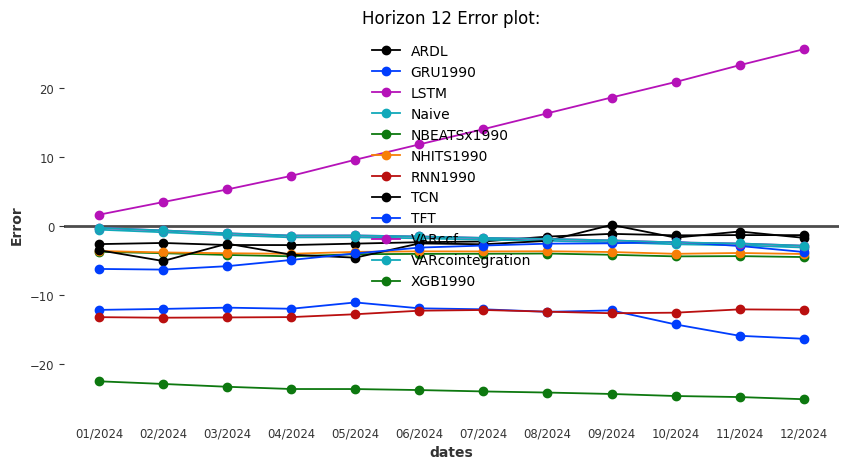

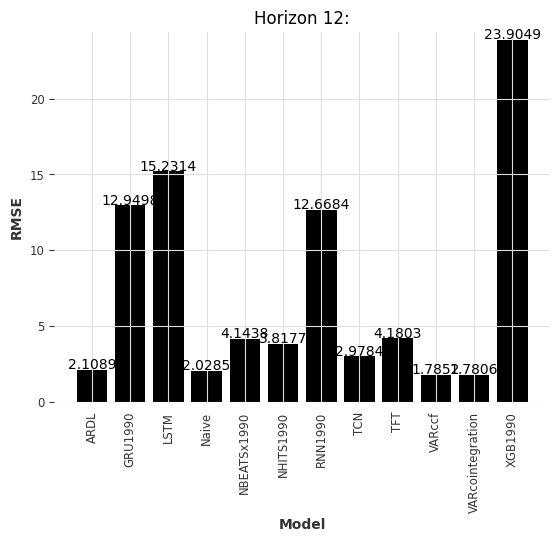

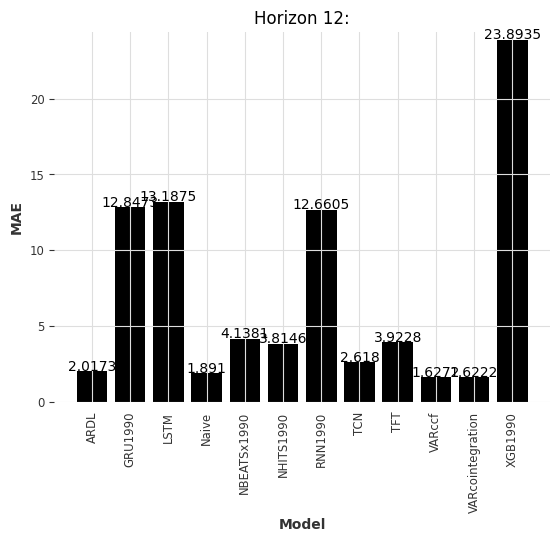

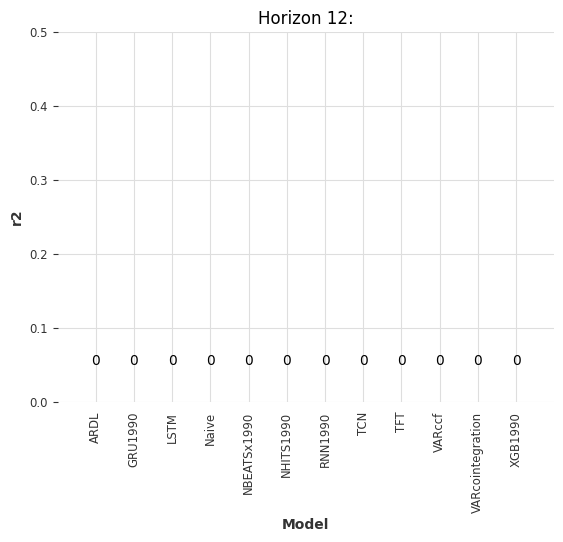

In [8]:
predsPath_12= Path('../Predictions/Horizon12')
predsDf_12=get_predictions(predsPath_12)

metrics_12= calc_metrics(predsDf_12)
display(metrics_12.sort_values(main_metric, axis=0))

error_plot(predsDf_12,model='all',absolute=False, title= 'Horizon 12 Error plot:')
for i in metrics_12.columns:
    plot_metric(metrics_12,i, title='Horizon 12:')